In [1]:
from PyTorch_CIFAR10.cifar10_models.mobilenetv2 import mobilenet_v2 
import torch # type:ignore
import torch.nn as nn # type:ignore
import torch.nn.functional as F # type:ignore
import torch.optim as optim # type:ignore
from torch.utils.data import DataLoader, random_split # type:ignore
from torchvision import datasets, transforms # type:ignore
import torchvision.models as models # type:ignore
from torchsummary import summary # type:ignore
import numpy as np # type:ignore
import pandas as pd # type:ignore
import matplotlib.pyplot as plt # type:ignore
from PyTorch_CIFAR10.UTILS_TORCH import *
from torchvision.transforms.functional import to_pil_image, to_tensor
plt.style.use(r"rw_visualization.mplstyle")

/Users/davidhernandez/anaconda3/envs/torch/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/davidhernandez/anaconda3/envs/torch/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <ABE0EE74-6D97-3B8C-B690-C44754774FBC> /Users/davidhernandez/anaconda3/envs/torch/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <CDAC6E34-8608-3E70-8B2F-32BCD38E90FB> /Users/davidhernandez/anaconda3/envs/torch/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# Load your precomputed IGs
igs = np.load("./PyTorch_CIFAR10/Teacher_igs_batch.npy")
captum_igs = np.load("./PyTorch_CIFAR10/Captum_IGs.npy")

In [3]:
min_factor = np.exp(np.log(0.6))
max_factor = np.exp(np.log(2))
IGs_scaled_min = captum_igs**min_factor
IGs_scaled_max = captum_igs**max_factor
captum_ig, _, _ = norm(captum_igs[0])
IG_scaled_min, _, _ = norm(IGs_scaled_min[0])
IG_scaled_max, _, _ = norm(IGs_scaled_max[0])

In [4]:
captum_igs[0].shape

(32, 32)

# DATA Loader

In [5]:
num_epochs = 100
batch_size = 64
learning_rate = 0.001

In [6]:
logits = np.load("PyTorch_CIFAR10/data/cifar10_logits.npy")

In [7]:
aug_transform = transforms.Compose([
    # transforms.RandomCrop(32, padding=4),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # transforms.Normalize(mean = [0.4914, 0.4822, 0.4465], std = [0.2471, 0.2435, 0.2616])
])

In [8]:
# Create an instance of the modified dataset with return_ig=True
sample_dataset = CIFAR10WithIG(igs=captum_igs, root='./PyTorch_CIFAR10/data', train=True, transform=aug_transform, overlay_prob=0.99, return_ig=True, precomputed_logits=logits)

Files already downloaded and verified


In [9]:
dataset = datasets.CIFAR10(root='./PyTorch_CIFAR10/data', train=True, download=True,
                           transform=transforms.ToTensor())

# Dictionary to store indices for each target
class_indices = {i: [] for i in range(10)}  # Initialize dictionary with lists for each class

# Iterate over the dataset
for idx, (_, target) in enumerate(dataset):
    # Append the index to the appropriate class list
    class_indices[target].append(idx)

# Optionally, print some indices to see the distribution
for key, value in class_indices.items():
    print(f"Class {key}: First 10 Indices: {value[:10]}")


Files already downloaded and verified
Class 0: First 10 Indices: [29, 30, 35, 49, 77, 93, 115, 116, 129, 165]
Class 1: First 10 Indices: [4, 5, 32, 44, 45, 46, 60, 61, 64, 65]
Class 2: First 10 Indices: [6, 13, 18, 24, 41, 42, 47, 48, 54, 55]
Class 3: First 10 Indices: [9, 17, 21, 26, 33, 36, 38, 39, 59, 74]
Class 4: First 10 Indices: [3, 10, 20, 28, 34, 58, 66, 82, 86, 89]
Class 5: First 10 Indices: [27, 40, 51, 56, 70, 81, 83, 107, 128, 148]
Class 6: First 10 Indices: [0, 19, 22, 23, 25, 72, 95, 103, 104, 117]
Class 7: First 10 Indices: [7, 11, 12, 37, 43, 52, 68, 73, 84, 85]
Class 8: First 10 Indices: [8, 62, 69, 92, 100, 106, 111, 135, 139, 155]
Class 9: First 10 Indices: [1, 2, 14, 15, 16, 31, 50, 53, 67, 71]


In [10]:
cls_id = sample_dataset.class_to_idx
cls_id

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [11]:
def get_key(val, my_dict):
  
    for key, value in my_dict.items():
        if val == value:
            return key

    return "key doesn't exist"

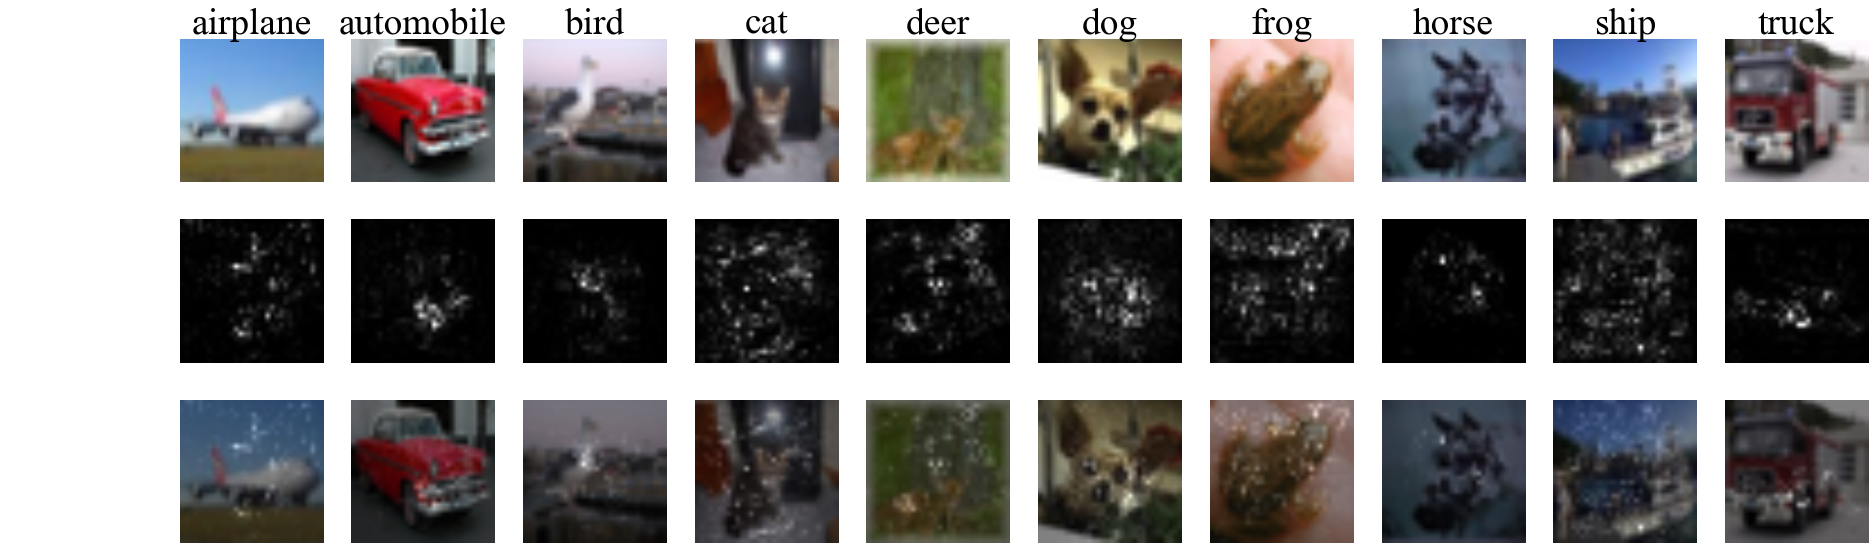

In [ ]:
# Number of classes
num_classes = 10
num_examples_per_class = 1  # Example: show 3 images per class
x = 0
y = 0.3
fs=36
font = 'Times New Roman'
# Create a figure with 3 rows (for img, ig, augmented_img) and columns based on examples
fig, axs = plt.subplots(3, num_classes * num_examples_per_class + 1, figsize=(30, 8))

for i in range(num_classes):
    # Randomly select indices (you can select them in any way you see fit)
    selected_indices = np.random.choice(class_indices[i], size=num_examples_per_class, replace=False)
    
    for j, idx in enumerate(selected_indices):
        img, ig, augmented_img, _ = sample_dataset[idx]  # assuming this returns tensors

        # Column position
        col = i * num_examples_per_class + j +1

        # Plot original image
        # axs[0,0].text(x,y,"Original \n Image", fontsize=fs, font=font)
        axs[0, 0].axis('off')
        axs[0, col].imshow(img.permute(1, 2, 0))  # permute for channel last format
        axs[0, col].axis('off')
        axs[0, col].set_title(f'{get_key(i, cls_id)}')

        # Plot integrated gradients
        # axs[1,0].text(x,y,"Integrated \n Gradients", fontsize=fs, font=font)
        axs[1, 0].axis('off')
        axs[1, col].imshow(ig.permute(1, 2, 0))  # similarly permute if necessary
        axs[1, col].axis('off')

        # Plot augmented image
        # axs[2,0].text(x,y,"Overlayed \n Image", fontsize=fs, font=font)
        axs[2, 0].axis('off')
        axs[2, col].imshow(augmented_img.permute(1, 2, 0))  # permute for channel last
        axs[2, col].axis('off')

plt.show()

In [13]:
img, ig, aug, _= sample_dataset[0]
image = img.permute(1,2,0).numpy()

In [14]:
image.max(), captum_igs.max(), IGs_scaled_min.max(), IGs_scaled_max.max()

(1.0, 32.93068876111689, 8.138802101859753, 1084.4302622815503)

In [15]:
def process_ig(ig):
    return np.repeat(np.expand_dims(ig, axis=3), 3, axis=-1)

In [16]:
igs_expanded = process_ig(captum_igs)
ig_scaled_min_exp = process_ig(IGs_scaled_min)
ig_scaled_max_exp = process_ig(IGs_scaled_max)
igs_expanded[0].shape, ig_scaled_min_exp[0].shape, ig_scaled_max_exp[0].shape

((32, 32, 3), (32, 32, 3), (32, 32, 3))

In [17]:
overlaid_img = 0.5 * image + 0.5 * igs_expanded[0]
norm_ig_scaled_min, _, _ = norm(ig_scaled_min_exp[0])
norm_ig_scaled_max, _, _ = norm(ig_scaled_max_exp[0])
overlaid_img_scaled_min = 0.5 * image + 0.5 * norm_ig_scaled_min
overlaid_img_scaled_max = 0.5 * image + 0.5 * norm_ig_scaled_max

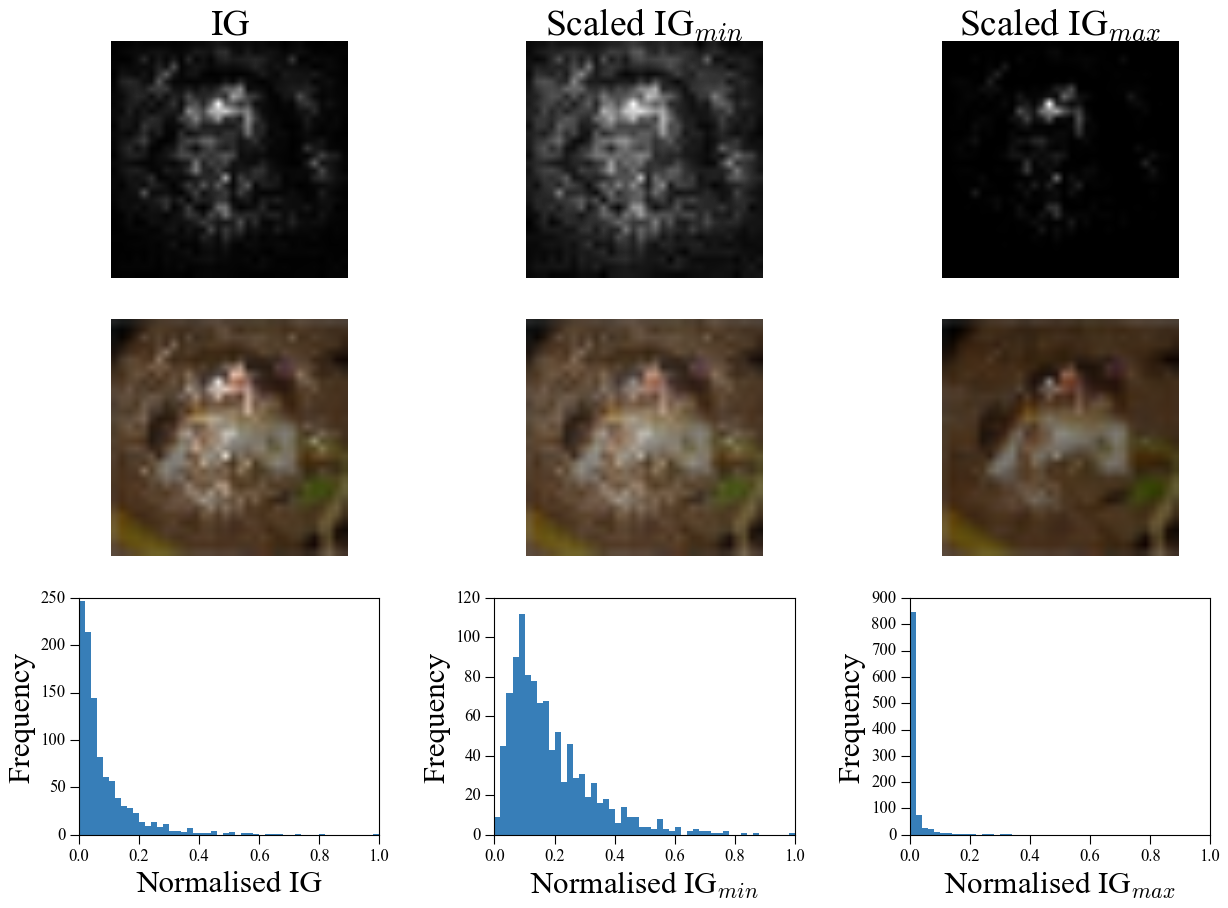

In [ ]:
plt.figure(figsize=(16,12))
plt.subplot(3,3,1)
plt.imshow(captum_ig, cmap='gray')
plt.axis('off')
plt.title("IG")
plt.subplot(3,3,2)
plt.imshow(IG_scaled_min, cmap='gray')
plt.axis('off')
plt.title("Scaled IG$_{min}$")
plt.subplot(3,3,3)
plt.imshow(IG_scaled_max, cmap='gray')
plt.axis('off')
plt.title("Scaled IG$_{max}$")

plt.subplot(3,3,4)
plt.imshow(overlaid_img, cmap='gray')
plt.axis('off')
plt.subplot(3,3,5)
plt.imshow(overlaid_img_scaled_min, cmap='gray')
plt.axis('off')
plt.subplot(3,3,6)
plt.imshow(overlaid_img_scaled_max, cmap='gray')
plt.axis('off')


plt.subplot(3,3,7)
plt.hist(captum_ig.flatten(), bins=50)
plt.xlabel("Normalised IG", fontsize=28)
plt.ylabel("Frequency", fontsize=28)
plt.subplot(3,3,8)
plt.hist(IG_scaled_min.flatten(), bins=50)
plt.xlabel("Normalised IG$_{min}$", fontsize=28)
plt.ylabel("Frequency", fontsize=28)
plt.subplot(3,3,9)
plt.hist(IG_scaled_max.flatten(), bins=50)
plt.xlabel("Normalised IG$_{max}$", fontsize=28)
plt.ylabel("Frequency", fontsize=28)
plt.tight_layout()
# plt.savefig("/Users/davidhernandez/Desktop/Nordling_Lab/nordlinglab-grants-publications/Article_Chang2024_integrated_gradients/sn_version_corrected/article/Figures/IG_scaled_comparison.pdf")
plt.show()